In [387]:
import requests as r
import pandas as pd
import json
import numpy as np
from tensorflow import keras
from keras.preprocessing.sequence import pad_sequences
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns

In [6]:
url='https://mobidb.bio.unipd.it/api/download?proteome=UP000005640&format=json'
proteome_data=r.get(url).json()

In [7]:
sequences=[protein['sequence'] for protein in proteome_data]

In [8]:
seqlengths=[len(sequence) for sequence in sequences]

In [9]:
sl=sorted(seqlengths)

In [10]:
np.array(sl)[-100:]

array([ 4557,  4563,  4579,  4588,  4589,  4590,  4599,  4624,  4640,
        4646,  4655,  4678,  4684,  4700,  4707,  4753,  4834,  4857,
        4859,  4861,  4869,  4870,  4873,  4911,  4950,  4967,  4969,
        4981,  5005,  5038,  5043,  5044,  5058,  5058,  5059,  5063,
        5070,  5088,  5121,  5142,  5150,  5179,  5183,  5202,  5207,
        5207,  5207,  5256,  5314,  5333,  5334,  5360,  5379,  5385,
        5386,  5388,  5405,  5412,  5478,  5497,  5537,  5537,  5596,
        5635,  5646,  5654,  5762,  5795,  5890,  6306,  6406,  6436,
        6448,  6450,  6464,  6516,  6669,  6818,  6824,  6885,  6907,
        7076,  7366,  7388,  7418,  7461,  7555,  7570,  7592,  7968,
        8384,  8392,  8560,  8749,  8797,  8923, 14507, 27118, 34350,
       35991])

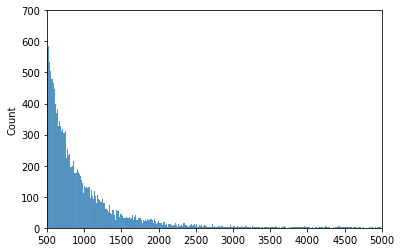

In [11]:
sns.histplot(sl)
plt.ylim(top=700)
plt.xlim((500,5000))
plt.savefig('plot_protsize.png')

In [12]:
surface_proteins[1]curated_data=[]
for n,node in enumerate(proteome_data):
    if len(node['sequence']) < 1500:
        curated_data.append(node)
    if n%10000==0:
        print('procesadas {} secuencias'.format(n))

procesadas 0 secuencias
procesadas 1000 secuencias
procesadas 2000 secuencias
procesadas 3000 secuencias
procesadas 4000 secuencias
procesadas 5000 secuencias
procesadas 6000 secuencias
procesadas 7000 secuencias
procesadas 8000 secuencias
procesadas 9000 secuencias
procesadas 10000 secuencias
procesadas 11000 secuencias
procesadas 12000 secuencias
procesadas 13000 secuencias
procesadas 14000 secuencias
procesadas 15000 secuencias
procesadas 16000 secuencias
procesadas 17000 secuencias
procesadas 18000 secuencias
procesadas 19000 secuencias
procesadas 20000 secuencias
procesadas 21000 secuencias
procesadas 22000 secuencias
procesadas 23000 secuencias
procesadas 24000 secuencias
procesadas 25000 secuencias
procesadas 26000 secuencias
procesadas 27000 secuencias
procesadas 28000 secuencias
procesadas 29000 secuencias
procesadas 30000 secuencias
procesadas 31000 secuencias
procesadas 32000 secuencias
procesadas 33000 secuencias
procesadas 34000 secuencias
procesadas 35000 secuencias
proce

In [13]:
with open('curated_sequences.json', 'w') as file:
    json.dump(curated_data, file)


In [133]:
data_fields=[key for key in curated_data[0].keys() if 'derived' not in key and 'prediction' not in key]

In [364]:
localized=[]
unlocalized=0
unnamed=0
otros_args=[]
hay_otros_args=0
for protein in curated_data:
    try:
        localized.append(protein['localization'])
    except KeyError as e:
        if e.args[0]=='localization':
            unlocalized+=1
        

In [365]:
locations=[]
for location in localized:
    locations+=location
locations=set(locations)

In [366]:
all_descriptors=[]
for location in locations:
    mezza=[]
    mezza_coma=location.split(',')
    for node in mezza_coma:
        mezza+=node.split(';')
    all_descriptors+=mezza
all_descriptors={node.strip() for node in all_descriptors}

In [367]:
colon_descriptor_categories=set()
colon_descriptors=set()
for node in all_descriptors:
    if ':' in node:
        colon_descriptors.add(node.lower())
        parts=node.split(':')
        assert len(parts) <= 2
        colon_descriptor_categories.add(parts[1].strip().lower())
colon_descriptor_categories

{'cell membrane',
 'cell surface',
 'cytoplasm',
 'cytoplasmic vesicle',
 'cytoplasmic vesicle membrane',
 'endomembrane system',
 'endoplasmic reticulum',
 'endoplasmic reticulum membrane',
 'golgi apparatus',
 'golgi apparatus membrane',
 'lysosome',
 'lysosome lumen',
 'membrane',
 'membrane raft',
 'mitochondrion',
 'mitochondrion inner membrane',
 'mitochondrion matrix',
 'mitochondrion membrane',
 'nucleus',
 'secreted',
 'virion'}

In [368]:
urefed_curated_data={}
cnte=0
cnt=0
for node in curated_data:
    try:
        _=node['localization']
        urefed_curated_data[node['uniref100']]=node
        cnt+=1
    except KeyError:
        cnte+=1
        pass

print(cnte,cnt)

50195 23117


In [369]:
with open('urefed_located_data.json', 'w') as file:
    json.dump(named_curated_data, file)

In [370]:
all_keys=[]
for node in curated_data:
    all_keys+=list(node.keys())

In [371]:
count={}
for key in all_keys:
    count[key]=0
for node in curated_data:
    for k in list(node.keys()):
        count[k]+=1

In [372]:
count_of_omniprescence=len(curated_data)
omnipresent_fields=[]
for key, value in count.items():
    if value == count_of_omniprescence:
        omnipresent_fields.append(key)

In [373]:
omnipresent_fields

['uniref100',
 'taxonomy',
 'sequence',
 'organism',
 'proteome',
 'length',
 'acc',
 'uniparc',
 'ncbi_taxon_id']

In [374]:
breaks=0
categorised_data=[]
for key, values in  urefed_curated_data.items():
    for value in values['localization']:
        if value.lower() in colon_descriptors or value.lower() in colon_descriptor_categories: 
            categorised_data.append({
                'uniref100':values['uniref100'],
                'localization':values['localization'],
                'sequence':values['sequence'],
                'cats':{'number':0,
                       'names':[]}
            })
            breaks+=1
            break
       

In [375]:
len(categorised_data), breaks

(11964, 11964)

In [ ]:
cell_membrane

In [376]:
surface=[]
mitochondrion=[]
other=[]
for node in sorted(list(colon_descriptor_categories)):
    if 'mitoch' in node:
        mitochondrion.append(node)
    elif 'cell' in node or 'membrane' in node and 'endo' not in node and 'golgi' not in node and 'cyto' not in node:
        surface.append(node)
    else:
        if 'golgi' in node or 'lyso' in node or 'endop' in node:
            other.append(node)

In [377]:
other, surface, mitochondrion

(['endoplasmic reticulum',
  'endoplasmic reticulum membrane',
  'golgi apparatus',
  'golgi apparatus membrane',
  'lysosome',
  'lysosome lumen'],
 ['cell membrane', 'cell surface', 'membrane', 'membrane raft'],
 ['mitochondrion',
  'mitochondrion inner membrane',
  'mitochondrion matrix',
  'mitochondrion membrane'])

In [378]:
labeled_data={
    'other':{},
    'mitochondrion':{},
    'surface':{}
}
deletable=[]
for datum in categorised_data:
    for value in datum['localization']:
        if value.lower() in other:
            labeled_data['other'][datum['uniref100']]=datum
            datum['cats']['number']+=1
            datum['cats']['names'].append('other')
        if value.lower() in mitochondrion:
            labeled_data['mitochondrion'][datum['uniref100']]=datum
            datum['cats']['number']+=1
            datum['cats']['names'].append('mitochondrion')
        if value.lower() in surface:
            labeled_data['surface'][datum['uniref100']]=datum
            datum['cats']['number']+=1
            datum['cats']['names'].append('surface')
        if datum['cats']['number'] > 1:
            deletable.append(datum)

In [379]:
clean_labeled_data=labeled_data.copy()
for repseq in deletable:
    cats=repseq['cats']['names']
    name=repseq['uniref100']
    for cat in cats:
        try:
            del clean_labeled_data[cat][name]
        except KeyError:
            pass
            #print(cat,name)

In [332]:
with open('processed_filtered_data.json', 'w') as file:
    json.dump(clean_labeled_data, file)

In [380]:
for k,v in clean_labeled_data.items():
    print('clase {} tiene {} datos'.format(k, len(v)))

clase other tiene 624 datos
clase mitochondrion tiene 808 datos
clase surface tiene 754 datos


In [428]:
mitochondrion_proteins=np.array([protein['sequence'] for uref, protein in clean_labeled_data['mitochondrion'].items() ])
surface_proteins=np.array([protein['sequence'] for uref, protein in clean_labeled_data['surface'].items() ])
all_prot_array=np.hstack([surface_proteins,mitochondrion_proteins])

In [429]:
allseqs=''
for sequence in all_prot_array:
    allseqs+=sequence
aas=set()
for val in allseqs:
    aas.add(val)
numeric_code={aa:num for num,aa in enumerate(aas,3)}
numeric_code

{'T': 3,
 'W': 4,
 'N': 5,
 'E': 6,
 'D': 7,
 'Y': 8,
 'V': 9,
 'Q': 10,
 'P': 11,
 'A': 12,
 'G': 13,
 'U': 14,
 'R': 15,
 'I': 16,
 'K': 17,
 'F': 18,
 'S': 19,
 'X': 20,
 'M': 21,
 'C': 22,
 'H': 23,
 'L': 24}

In [455]:
surface_proteins_numeric=[]
for sequence in surface_proteins:
    sequence_array=np.zeros(len(sequence), dtype=int)
    for n,amino_acid in enumerate(sequence):
        sequence_array[n]=numeric_code[amino_acid]
    surface_proteins_numeric.append(sequence_array)
surface_proteins_numeric=np.array(surface_proteins_numeric)
mitochondrion_proteins_numeric=[]
for sequence in mitochondrion_proteins:
    sequence_array=np.zeros(len(sequence), dtype=int)
    for n,amino_acid in enumerate(sequence):
        sequence_array[n]=numeric_code[amino_acid]
    mitochondrion_proteins_numeric.append(sequence_array)
mitochondrion_proteins_numeric=np.array(mitochondrion_proteins_numeric)



/tmp/ipykernel_756/1075402229.py:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  surface_proteins_numeric=np.array(surface_proteins_numeric)
/tmp/ipykernel_756/1075402229.py:14: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  mitochondrion_proteins_numeric=np.array(mitochondrion_proteins_numeric)


In [460]:
padded_surface_proteins=pad_sequences(surface_proteins_numeric,padding='post', maxlen=1500)
padded_mitochondrion_proteins=pad_sequences(mitochondrion_proteins_numeric,padding='post',maxlen=1500)

In [461]:
np.save('padded_surface_proteins', padded_surface_proteins)
np.save('padded_mitochondrion_proteins',padded_mitochondrion_proteins)

In [462]:
padded_surface_proteins.shape, padded_mitochondrion_proteins.shape

((754, 1500), (808, 1500))

In [478]:
data=np.vstack([padded_surface_proteins, padded_mitochondrion_proteins])

In [479]:
labels=np.hstack([np.zeros(padded_surface_proteins.shape[0]),np.ones(padded_mitochondrion_proteins.shape[0])]).reshape(-1,1)

In [480]:
np.savez('preprocessed_data', data=data, labels=labels)

In [481]:
npzfile=np.load('preprocessed_data.npz')

In [484]:
pwd

'/home/gonik/Documents/git/bioproject'